In [1]:
import pandas as pd
import networkx as nx
import igviz as ig

In [2]:
characters_df = pd.read_csv('../data/SilasMarner/processed_characters.csv')
characters_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name
0,48,32,533,534,PROP,PER,Silas Marner,"father Silas , who had taken her golden curls ..."
1,49,32,538,538,PRON,PER,his,"father Silas , who had taken her golden curls ..."
2,55,32,573,573,PROP,PER,Silas,"father Silas , who had taken her golden curls ..."
3,61,32,675,675,PROP,PER,Marner,"father Silas , who had taken her golden curls ..."
4,62,32,683,683,PRON,PER,his,"father Silas , who had taken her golden curls ..."
...,...,...,...,...,...,...,...,...
6563,11688,32,86599,86599,PROP,PER,Silas,"father Silas , who had taken her golden curls ..."
6564,11690,61,86605,86605,PRON,PER,he,the artful Godfrey
6565,11691,144,86607,86607,PROP,PER,Eppie,little curly - headed Eppie
6566,11699,144,86672,86672,PROP,PER,Eppie,little curly - headed Eppie


In [3]:
tokens_df = pd.read_csv('../data/SilasMarner/character-tagging/SilasMarner.tokens', delimiter='\t')
tokens_df

,paragraph_ID,sentence_ID,token_ID_within_sentence,token_ID_within_document,word,lemma,byte_onset,byte_offset,POS_tag,fine_POS_tag,dependency_relation,syntactic_head_ID,event
0,0,0,0,0,In,in,0,2,ADP,IN,prep,27,O
1,0,0,1,1,the,the,3,6,DET,DT,det,2,O
2,0,0,2,2,days,day,7,11,NOUN,NNS,pobj,0,O
3,0,0,3,3,when,when,12,16,SCONJ,WRB,advmod,8,O
4,0,0,4,4,the,the,17,20,DET,DT,det,7,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86688,814,2527,6,86688,than,than,391550,391554,SCONJ,IN,mark,86690,O
86689,814,2527,7,86689,we,we,391555,391557,PRON,PRP,nsubj,86690,O
86690,814,2527,8,86690,are,be,391558,391561,AUX,VBP,advcl,86687,O
86691,814,2527,9,86691,.,.,391561,391562,PUNCT,.,punct,86683,O


In [4]:
# Paragraph based network

characters_paragraph_mention_df = characters_df.copy()
characters_paragraph_mention_df['paragraph'] = characters_paragraph_mention_df.start_token.map(
    lambda x: tokens_df.iloc[x].paragraph_ID
)
characters_paragraph_mention_df

,Unnamed: 0,COREF,start_token,end_token,prop,cat,text,character_name,paragraph
0,48,32,533,534,PROP,PER,Silas Marner,"father Silas , who had taken her golden curls ...",1
1,49,32,538,538,PRON,PER,his,"father Silas , who had taken her golden curls ...",1
2,55,32,573,573,PROP,PER,Silas,"father Silas , who had taken her golden curls ...",1
3,61,32,675,675,PROP,PER,Marner,"father Silas , who had taken her golden curls ...",1
4,62,32,683,683,PRON,PER,his,"father Silas , who had taken her golden curls ...",1
...,...,...,...,...,...,...,...,...,...
6563,11688,32,86599,86599,PROP,PER,Silas,"father Silas , who had taken her golden curls ...",813
6564,11690,61,86605,86605,PRON,PER,he,the artful Godfrey,813
6565,11691,144,86607,86607,PROP,PER,Eppie,little curly - headed Eppie,813
6566,11699,144,86672,86672,PROP,PER,Eppie,little curly - headed Eppie,814


In [5]:
paragraph_windows = 10
paragraphs_per_window = characters_paragraph_mention_df.paragraph.max() // paragraph_windows

sizes = paragraph_windows * [paragraphs_per_window]
for i in range(characters_paragraph_mention_df.paragraph.max() - sum(sizes)):
    sizes[i] += 1

In [6]:
graphs = []

G = nx.Graph()

curr_graph = 0

for paragraph, sub_df in characters_paragraph_mention_df.groupby(characters_paragraph_mention_df.paragraph):
    
    if paragraph > sizes[curr_graph] + sum(sizes[:curr_graph]):
        graphs.append(G)
        curr_graph += 1
        G = nx.Graph()
    
    if sub_df.character_name.unique().size == 1:
        continue
    
    pairs = []
    for i, name in enumerate(sub_df.character_name.unique()):
        
        if name not in G.nodes:
            G.add_node(name, connections=sub_df.character_name.unique().size - 1)
        else:
            G.nodes[name]['connections'] += sub_df.character_name.unique().size - 1

        for o_name in sub_df.character_name.unique()[i + 1:]:
            
            if o_name not in G.nodes:
                G.add_node(o_name, connections=0)
            if (name, o_name) not in G.edges:
                G.add_edge(name, o_name, weight=1)
            else:
                G.edges[name, o_name]['weight'] += 1

In [7]:
window = 5

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_17868\2433330430.py:14: DeprecationWarning: Argument `titlefont_size` is deprecated and will be removed in 0.6.0.
  ig.plot(


FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': '49b3b1c2-0f9f-47ea-99a5-b81486fcae52',
              'x': [-0.07551919561705013, -0.3023000548757969, None,
                    -0.07551919561705013, -0.5509695523337707, None,
                    -0.07551919561705013, -0.9639165454522559, None,
                    -0.07551919561705013, 0.18992356501869187, None,
                    -0.07551919561705013, 0.4450823993053782, None,
                    -0.07551919561705013, 0.7195230145599502, None,
                    -0.07551919561705013, 0.18022144883841576, None,
                    -0.07551919561705013, 0.34829294965082674, None,
                    -0.07551919561705013, 0.1697558206264617, None,
                    -0.07551919561705013, 0.4779413766002956, None,
                    -0.07551919561705013, 0.35807750896

In [8]:
# Ego Networks

character_of_interest = 'father Silas , who had taken her golden curls for his lost guineas brought back to him'

for graph in graphs:
    remove_nodes = []
    for node in graph.nodes:
        if node == character_of_interest:
            continue

        if not (node, character_of_interest) in graph.edges:
            for _, other_node in graph.edges(node):
                graph.nodes[other_node]['connections'] -= graph.edges[node, other_node]['weight']
            remove_nodes.append(node)
    for node in remove_nodes:
        graph.remove_node(node)

In [9]:
window = 5

color_list = []
sizing_list = []

G = graphs[window]

for node in G.nodes():
    size_and_color = G.nodes[node]['connections']

    color_list.append(size_and_color)
    sizing_list.append(size_and_color)

ig.plot(
    G,
    title=f"Window {window} {character_of_interest} Ego Social Network",
    layout="spring",
    size_method=sizing_list, # Makes node sizes the size of the "prop" property
    color_method=color_list, # Colors the nodes based off the "prop" property and a color scale,
    edge_label="weight", # Display the "edge_prop" attribute on the edge
    edge_label_position="bottom center", # Display the edge label below the edge
    node_text=['connections']
)

C:\Users\decla\AppData\Local\Temp\ipykernel_17868\1327605136.py:14: DeprecationWarning:

Argument `titlefont_size` is deprecated and will be removed in 0.6.0.



FigureWidget({
    'data': [{'hoverinfo': 'text',
              'line': {'color': '#888', 'width': 1},
              'mode': 'lines+text',
              'text': [],
              'type': 'scatter',
              'uid': 'df1e45c9-3c1f-48da-be51-d89314119763',
              'x': [0.09382678173353656, -0.05282686485328557, None,
                    0.09382678173353656, 0.0008619958497169906, None,
                    0.09382678173353656, -0.3060919517831103, None,
                    0.09382678173353656, 0.6295604061454527, None,
                    0.09382678173353656, 0.5354542387853549, None,
                    0.09382678173353656, -0.22926476964269965, None,
                    0.09382678173353656, 0.05161518524679545, None,
                    0.09382678173353656, 0.16000446380438993, None,
                    -0.05282686485328557, -0.2615664736568996, None,
                    -0.05282686485328557, 0.0008619958497169906, None,
                    -0.05282686485328557, -0.3060919517

In [10]:
from collections import defaultdict

per_window_importances = {}


for i, window_graph in enumerate(graphs):
    for _, other_char in window_graph.edges(character_of_interest):
        if other_char not in per_window_importances:
            per_window_importances[other_char] = len(graphs) * [0]

        per_window_importances[other_char][i] = window_graph.nodes[other_char]['connections']

sorted_keys = sorted(per_window_importances, key=lambda x: sum(per_window_importances[x]), reverse=True)

In [11]:
top_10_characters = {key: per_window_importances[key] for key in sorted_keys[:10]}

In [13]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10., 6.)

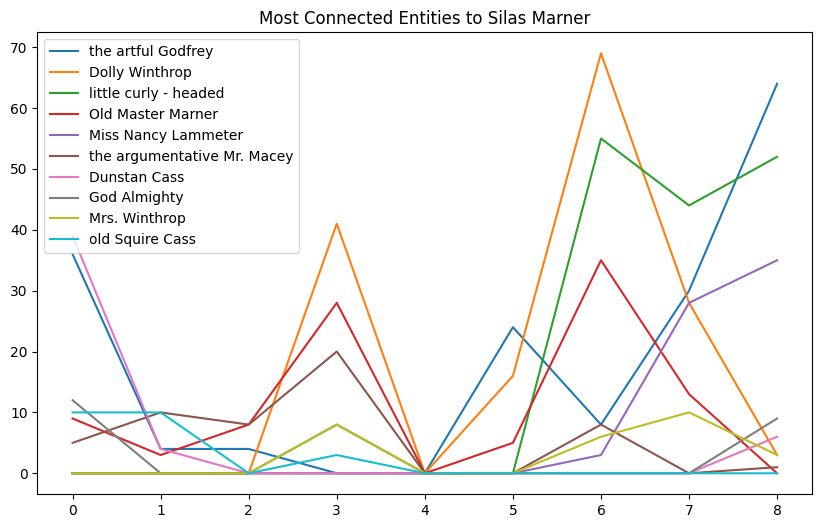

In [14]:
axis = np.arange(len(graphs))

for character, counts in top_10_characters.items():
    character_short_name = ' '.join(character.split()[:4])
    plt.plot(axis, counts, label=character_short_name)

plt.title('Most Connected Entities to Silas Marner')
plt.legend()

plt.savefig('silas-marner-top-10.png')
plt.show()

In [14]:
graphs[0].nodes

NodeView(('father Silas , who had taken her golden curls for his lost guineas brought back to him', 'Jem Rodney', 'old Squire Cass', 'the argumentative Mr. Macey', 'Old Master Marner', 'Sally Oates', 'William Dane', 'God Almighty', 'Poor Marner', 'the Raveloe', 'Mrs. Osgood', 'Dunstan Cass', 'Dunsey Cass', 'the artful Godfrey', 'old Bryce', 'Wildfire'))